In [45]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings("ignore")

In [46]:
def Black76Call(S, K, disc, sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(S*norm.cdf(d1) - K*norm.cdf(d2))

def Black76Put(S, K, disc, sigma, T):
    d1 = (np.log(S/K)+sigma**2/2*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return disc*(K*norm.cdf(-d2) - S*norm.cdf(-d1))

def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*log(F/X)
        zhi = log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [47]:
def IRR(x,N,m):
    IRR=np.zeros(N*m)
    IRRS=0
    for i in range(N*m):
        IRR[i]= 1/m / (1+x/m)**i
    IRRS=np.sum(IRR[:])
    return IRRS

def IRRf(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRf = (IRRplus - IRRminus) / (2*dx)
    return IRRf

def IRRff(x,N,m):
    dx = 0.05 * x
    IRRplus= IRR(x+dx,N,m)
    IRRx = IRR(x,N,m)
    IRRminus = IRR (x-dx,N,m)
    IRRff = (IRRplus - 2*IRRx + IRRminus) / (dx**2)
    return IRRff

def hff(x, N, m, F, sigma, T):
    h = (-IRRff(x,N,m) * x - 2 * IRRf(x,N,m) ) / (IRR(x,N,m)**2) +\
        2 * IRRf(x,N,m)**2 * x / IRR(x,N,m)**3
    return h

def integral1(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m, F, sigma, T)
    Vrec = Black76Put(F, x, disc,sigma, T)
    return h*Vrec

def integral2(x,N,m,F,disc,sigma,T):
    h = hff(x, N, m, F, sigma, T)
    Vpay = Black76Call(F, x, disc,sigma, T)
    return h*Vpay

## Q2. Calculate the CMS rate

In [48]:
alpha = pd.read_csv('sabr_alpha.csv', header = 0, index_col = 0 )
rho = pd.read_csv('sabr_rho.csv', header = 0, index_col = 0)
nu = pd.read_csv('sabr_nu.csv', header = 0, index_col = 0)

In [49]:
fsr = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)

In [50]:
Expiry = ['1Y','5Y','10Y']
Tenor = ['1Y','2Y','3Y','5Y','10Y']

In [51]:
CMS_Rate=pd.DataFrame(np.zeros((3,5)),index=Expiry,columns=Tenor)

In [52]:
for ex in Expiry:
    for te in Tenor:
        F = fsr.loc[ex, te]
        T = int(ex.strip()[:-1])
        ex_int = int(ex.strip()[:-1])
        te_int = int(te.strip()[:-1])
        N = ex_int + te_int
        sigma = SABR(F, F, T, alpha.loc[ex, te], 0.9, rho.loc[ex, te], nu.loc[ex,te])
        term1 = quad(lambda x:integral1(x,N,1,F,IRR(F, N, 1), sigma, T),0,F)
        term2 = quad(lambda x:integral2(x,N,1,F,IRR(F, N, 1), sigma, T),F,np.inf)
        
        CMS_Rate.loc[ex,te] = F + np.sum(term1 + term2)

In [53]:
CMS_Rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032029,0.033345,0.034158,0.035458,0.038848
5Y,0.040797,0.042537,0.043012,0.044087,0.047919
10Y,0.052273,0.055587,0.058432,0.060292,0.071928


In [54]:
# compare with the forward swap rate
FW_rate = pd.read_csv('forward_swap_rate.csv', header = 0, index_col = 0)
FW_rate

,1Y,2Y,3Y,5Y,10Y
1Y,0.032007,0.033259,0.034011,0.035255,0.038428
5Y,0.039274,0.040075,0.040072,0.041093,0.043634
10Y,0.042189,0.043116,0.044097,0.046249,0.053458


In [55]:
comparison = []
for x in Expiry:
    for y in Tenor:
        rate_diff =  CMS_Rate.loc[x,y] - FW_rate.loc[x,y]
        comparison.append(rate_diff)

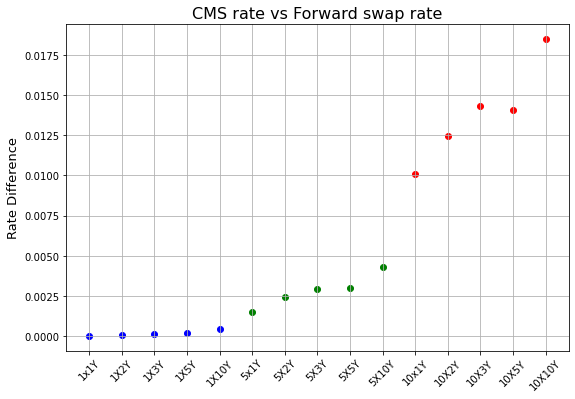

In [56]:
plt.figure(figsize = (9, 6))
plt.scatter(['1x1Y', '1X2Y', '1X3Y', '1X5Y', '1X10Y'], comparison[:5], c = 'b')
plt.scatter(['5x1Y', '5X2Y', '5X3Y', '5X5Y', '5X10Y'], comparison[5:10], c = 'g')
plt.scatter(['10x1Y', '10X2Y', '10X3Y', '10X5Y', '10X10Y'], comparison[10:], c = 'r')
plt.grid()
plt.xticks(rotation = 45)
plt.title('CMS rate vs Forward swap rate', fontsize = 16)
plt.ylabel('Rate Difference', fontsize = 13);

## Q1.1 value the PV of receiving leg

In [57]:
dis = pd.read_csv('discount_factor.csv', header = 0)

In [58]:
dis

,Tenor,OIS_DF,Libor_DF
0,0.5,0.998752,0.987654
1,1.0,0.997009,0.972577
2,1.5,0.995270,0.957378
3,2.0,0.993531,0.942179
4,2.5,0.991773,0.926330
5,3.0,0.990015,0.910482
6,3.5,0.988066,0.894731
7,4.0,0.986117,0.878981
8,4.5,0.984150,0.863985
9,5.0,0.982184,0.848989


In [59]:

start = ['0.5Y', '1Y', '1.5Y', '2Y', '2.5Y', '3Y', '3.5Y',
        '4Y', '4.5Y', '5Y']
tenor = ['10Y']

# get the forward swap rate for (0.5 x 10) till (5X 10)
forward = []
for ex in start:
    for te in tenor:
        i = float(ex.strip()[:-1])
        j = float(te.strip()[:-1])
        numer = dis[dis.Tenor == i].Libor_DF.values[0] -\
                dis[dis.Tenor == (i+j)].Libor_DF.values[0]
        deno = 0.5 * sum(dis.Libor_DF[int(2*i): int(2*(i+j))])
        forward.append(numer/deno)

In [60]:
forward

[0.03748288829152484,
 0.03808362144855073,
 0.03868985687234781,
 0.03931739428975165,
 0.039880560084025345,
 0.040462083600653426,
 0.04107658555456484,
 0.041712247979083183,
 0.04247980101251978,
 0.043278049210572406]

In [61]:
data = pd.DataFrame({'Start': start, 'Tenor':tenor * 10, 
              'FS' : forward,
              'DF' : dis.OIS_DF[:10],
              'alpha': np.NaN,
              'rho': np.NaN,
              'nu': np.NaN})
data 

,Start,Tenor,FS,DF,alpha,rho,nu
0,0.5Y,10Y,0.037483,0.998752,NaN,NaN,NaN
1,1Y,10Y,0.038084,0.997009,NaN,NaN,NaN
2,1.5Y,10Y,0.038690,0.995270,NaN,NaN,NaN
3,2Y,10Y,0.039317,0.993531,NaN,NaN,NaN
4,2.5Y,10Y,0.039881,0.991773,NaN,NaN,NaN
5,3Y,10Y,0.040462,0.990015,NaN,NaN,NaN
6,3.5Y,10Y,0.041077,0.988066,NaN,NaN,NaN
7,4Y,10Y,0.041712,0.986117,NaN,NaN,NaN
8,4.5Y,10Y,0.042480,0.984150,NaN,NaN,NaN
9,5Y,10Y,0.043278,0.982184,NaN,NaN,NaN


In [62]:
data.iloc[1,4] = 0.171097
data.iloc[9,4] = 0.174306
data.iloc[1,5] = -0.263488
data.iloc[9,5] = -0.408565
data.iloc[1,6] = 0.768787
data.iloc[9,6] = 0.508502

In [63]:
data['alpha'] = data.alpha.interpolate(limit_direction = 'both')

In [64]:
data['nu'] = data.nu.interpolate(limit_direction = 'both')
data['rho'] = data.rho.interpolate(limit_direction = 'both')

In [65]:
data['CMS'] = np.NaN

In [66]:
for i in range(0, 10):
    F = data.FS[i]
    T = (i+1)/2
    N = 5
    m = 2 #semi-annually
    sigma = SABR(F, F, T, data.alpha[i], 0.9, data.rho[i],data.nu[i] )
    term1 = quad(lambda x:integral1(x,N,m,F,IRR(F, N, m), sigma, T),0,F)
    term2 = quad(lambda x:integral2(x,N,m,F,IRR(F, N, m), sigma, T),F,np.inf)
        
    data.CMS[i] = F + np.sum(term1 + term2)

In [67]:
data

,Start,Tenor,FS,DF,alpha,rho,nu,CMS
0,0.5Y,10Y,0.037483,0.998752,0.171097,-0.263488,0.768787,0.037573
1,1Y,10Y,0.038084,0.997009,0.171097,-0.263488,0.768787,0.038278
2,1.5Y,10Y,0.038690,0.995270,0.171498,-0.281623,0.736251,0.039002
3,2Y,10Y,0.039317,0.993531,0.171899,-0.299757,0.703716,0.039761
4,2.5Y,10Y,0.039881,0.991773,0.172300,-0.317892,0.671180,0.040464
5,3Y,10Y,0.040462,0.990015,0.172702,-0.336027,0.638645,0.041195
6,3.5Y,10Y,0.041077,0.988066,0.173103,-0.354161,0.606109,0.041968
7,4Y,10Y,0.041712,0.986117,0.173504,-0.372296,0.573573,0.042769
8,4.5Y,10Y,0.042480,0.984150,0.173905,-0.390430,0.541038,0.043715
9,5Y,10Y,0.043278,0.982184,0.174306,-0.408565,0.508502,0.044700


In [68]:
import matplotlib.pyplot as plt

In [69]:
# PV of a leg receiving CMS10y semi-annually over the next 5 years 

PV = []
for i in range(0, 10):
    PV.append(0.5 * data.DF[i] * data.CMS[i])
sum(PV)

0.20274716709278046

In [70]:
data.to_csv('CMS_10Y.csv')

## Q1.2 PV of a leg receiving CMS2y quartly over the next 10 years

In [71]:
data2 = pd.DataFrame(np.zeros((50,3)),columns=['Tenor','OIS_DF', 'Libor_DF'])
data2['Tenor'] = np.linspace(0.25, 12.5, 50 )
data2['OIS_DF'] = np.NaN
data2['Libor_DF'] = np.NaN

In [72]:
dis2 = dis.set_index('Tenor')

In [73]:
data2 = data2.set_index('Tenor')

In [74]:
data2['OIS_DF'] = dis2['OIS_DF']
data2['Libor_DF'] = dis2['Libor_DF']

In [75]:
data2['OIS_DF'] = data2['OIS_DF'].interpolate(limit_direction = 'both')
data2['Libor_DF'] = data2['Libor_DF'].interpolate(limit_direction = 'both')

In [76]:
data3 = data2.reset_index()
data3

,Tenor,OIS_DF,Libor_DF
0,0.25,0.998752,0.987654
1,0.50,0.998752,0.987654
2,0.75,0.997880,0.980116
3,1.00,0.997009,0.972577
4,1.25,0.996139,0.964977
5,1.50,0.995270,0.957378
6,1.75,0.994400,0.949778
7,2.00,0.993531,0.942179
8,2.25,0.992652,0.934255
9,2.50,0.991773,0.926330


In [77]:
forward2 = []
for i in range(0, 40):
    fs= (data3.Libor_DF[i] - data3.Libor_DF[i+8])/( 0.25*data3.Libor_DF[i+1:i+9].sum())
    forward2.append(fs)

In [78]:
da = data3.iloc[:40, :]

In [79]:
da['FS'] = forward2

In [80]:
da['alpha'] = np.NaN
da['rho'] = np.NaN
da['nu'] = np.NaN

In [81]:
da.iloc[3, 4] = 0.184658
da.iloc[19, 4] = 0.199516
da.iloc[39, 4] = 0.195447
da.iloc[3, 5] = -0.524941
da.iloc[19, 5] = -0.546848
da.iloc[39, 5] = -0.544792
da.iloc[3, 6] = 1.676085
da.iloc[19, 6] = 1.061446
da.iloc[39, 6] = 0.925469

In [82]:
da.alpha = da.alpha.interpolate(limit_direction = 'both')
da.rho = da.alpha.interpolate(limit_direction = 'both')
da.nu = da.nu.interpolate(limit_direction = 'both')

In [83]:
da['CMS'] = np.NaN

In [84]:
for i in range(0, 40):
    F = da.FS[i]
    T = (i+1)/4
    N = 10
    m = 4
    sigma = SABR(F, F, T, da.alpha[i], 0.9, da.rho[i],da.nu[i] )
    term1 = quad(lambda x:integral1(x,N,m,F,IRR(F, N, m), sigma, T),0,F)
    term2 = quad(lambda x:integral2(x,N,m,F,IRR(F, N, m), sigma, T),F,np.inf)
        
    da.CMS[i] = F + np.sum(term1 + term2)

In [85]:
da

,Tenor,OIS_DF,Libor_DF,FS,alpha,rho,nu,CMS
0,0.25,0.998752,0.987654,0.027780,0.184658,0.184658,1.676085,0.027853
1,0.50,0.998752,0.987654,0.032159,0.184658,0.184658,1.676085,0.032374
2,0.75,0.997880,0.980116,0.032625,0.184658,0.184658,1.676085,0.032999
3,1.00,0.997009,0.972577,0.033101,0.184658,0.184658,1.676085,0.033677
4,1.25,0.996139,0.964977,0.033526,0.185587,0.185587,1.637670,0.034348
5,1.50,0.995270,0.957378,0.033961,0.186515,0.186515,1.599255,0.035076
6,1.75,0.994400,0.949778,0.034403,0.187444,0.187444,1.560840,0.035868
7,2.00,0.993531,0.942179,0.034855,0.188372,0.188372,1.522425,0.036728
8,2.25,0.992652,0.934255,0.034922,0.189301,0.189301,1.484010,0.037223
9,2.50,0.991773,0.926330,0.034988,0.190230,0.190230,1.445595,0.037765


In [86]:
da.to_csv('CMS_2Y.csv')

In [87]:
# PV of a leg receiving CMS2y quarterly over the next 10 years 
PV = []
for i in range(0, 40):
    PV.append(0.25 * da.OIS_DF[i] * da.CMS[i])
sum(PV)

0.5829559552364424